In [764]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, recall_score
from sklearn.model_selection import train_test_split
import shap

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

random_state = 0

In [640]:
df_y = pd.read_csv('y_train.csv')
df_demo = pd.read_csv('demo.csv')
df_cardinfo = pd.read_csv('card_info.csv')
df_cctxn = pd.read_csv('cc_txn.csv')
df_sabal = pd.read_csv('sa_bal.csv')
df_dtxn = pd.read_csv('dtxn.csv')

all_df = {'df_y - Output for selected user ids':df_y,
        'df_demo - Personal information of customers':df_demo,
        'df_cardinfo - Credit card information':df_cardinfo,
        'df_cctxn - Credit card transaction log':df_cctxn,
        'df_sabal - Saving account balance aggregated by months':df_sabal,
        'df_dtxn - Incoming and outgoing transactions aggregated by months (exclude credit card transactions)':df_dtxn}

# all_df = [df_y, df_demo, df_cardinfo, df_cctxn, df_sabal, df_dtxn]

In [641]:
# head
for df in all_df:
    print(f"Head of DataFrame: {df} - {all_df[df].shape}:")
    display(all_df[df].head(3))
    print('\n' + '='*50 + '\n')

Head of DataFrame: df_y - Output for selected user ids - (494, 2):


,user_id,label
0,2723,1.0
1,44088,1.0
2,3139,0.0




Head of DataFrame: df_demo - Personal information of customers - (52762, 7):


,user_id,account_start_date,birth_year,gender,marital_status,family_income_segment_code,individual_income_segment_code
0,27616,1975-04-15,1961.0,F,,06,04
1,14619,1971-01-31,1943.0,F,1,04,09
2,13595,1960-11-24,1952.0,F,1,07,07




Head of DataFrame: df_cardinfo - Credit card information - (60296, 4):


,user_id,bill_cyc,cr_lmt_amt,card_no
0,0,17.0,244000,0
1,1,12.0,361000,1
2,2,12.0,385000,2




Head of DataFrame: df_cctxn - Credit card transaction log - (3223075, 5):


,mcc,txn_dt,user_id,txn_amt,card_no
0,mcc_cat10,2017-04-12,17863,16391.0,21616.0
1,mcc_cat11,2017-07-12,7682,117200.0,9438.0
2,mcc_cat12,2017-05-23,33603,55602.0,39476.0




Head of DataFrame: df_sabal - Saving account balance aggregated by months - (633144, 3):


,user_id,mm,max_sa_bal
0,0,1,535052.0
1,0,10,0.0
2,0,11,161530.0




Head of DataFrame: df_dtxn - Incoming and outgoing transactions aggregated by months (exclude credit card transactions) - (490599, 4):


,user_id,mm,amt_in,amt_out
0,0,1,17725.0,4490.0
1,0,2,12431.0,29286.0
2,0,3,86274.0,0.0


In [642]:
# null checking
for df in all_df:
    print(f"Null check of DataFrame: {df} - {all_df[df].shape}:")

    # Clean undetectable null values
    for col in all_df[df].columns:
        if all_df[df][col].dtype == 'O':  # 'O' represents object (string) type
            all_df[df][col] = all_df[df][col].str.strip()

    all_df[df].replace('', np.nan, inplace=True)

    print(all_df[df].isnull().sum()/len(all_df[df]))

    print('\n' + '='*50 + '\n')

Null check of DataFrame: df_y - Output for selected user ids - (494, 2):
user_id    0.0
label      0.0
dtype: float64


Null check of DataFrame: df_demo - Personal information of customers - (52762, 7):


user_id                           0.000000
account_start_date                0.000000
birth_year                        0.000000
gender                            0.000000
marital_status                    0.233028
family_income_segment_code        0.129298
individual_income_segment_code    0.060631
dtype: float64


Null check of DataFrame: df_cardinfo - Credit card information - (60296, 4):
user_id       0.0
bill_cyc      0.0
cr_lmt_amt    0.0
card_no       0.0
dtype: float64


Null check of DataFrame: df_cctxn - Credit card transaction log - (3223075, 5):
mcc        0.0
txn_dt     0.0
user_id    0.0
txn_amt    0.0
card_no    0.0
dtype: float64


Null check of DataFrame: df_sabal - Saving account balance aggregated by months - (633144, 3):
user_id       0.0
mm            0.0
max_sa_bal    0.0
dtype: float64


Null check of DataFrame: df_dtxn - Incoming and outgoing transactions aggregated by months (exclude credit card transactions) - (490599, 4):
user_id    0.0
mm         0.0
amt_in 

In [643]:
# info
for df in all_df:
    print(f"Head of DataFrame: {df} - {all_df[df].shape}:")
    display(all_df[df].info())
    print('\n' + '='*50 + '\n')

Head of DataFrame: df_y - Output for selected user ids - (494, 2):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494 entries, 0 to 493
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  494 non-null    int64  
 1   label    494 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 7.8 KB


None



Head of DataFrame: df_demo - Personal information of customers - (52762, 7):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52762 entries, 0 to 52761
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   user_id                         52762 non-null  int64  
 1   account_start_date              52762 non-null  object 
 2   birth_year                      52762 non-null  float64
 3   gender                          52762 non-null  object 
 4   marital_status                  40467 non-null  object 
 5   family_income_segment_code      45940 non-null  object 
 6   individual_income_segment_code  49563 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 2.8+ MB


None



Head of DataFrame: df_cardinfo - Credit card information - (60296, 4):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60296 entries, 0 to 60295
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   user_id     60296 non-null  int64  
 1   bill_cyc    60296 non-null  float64
 2   cr_lmt_amt  60296 non-null  int64  
 3   card_no     60296 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 1.8 MB


None



Head of DataFrame: df_cctxn - Credit card transaction log - (3223075, 5):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3223075 entries, 0 to 3223074
Data columns (total 5 columns):
 #   Column   Dtype  
---  ------   -----  
 0   mcc      object 
 1   txn_dt   object 
 2   user_id  int64  
 3   txn_amt  float64
 4   card_no  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 123.0+ MB


None



Head of DataFrame: df_sabal - Saving account balance aggregated by months - (633144, 3):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 633144 entries, 0 to 633143
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     633144 non-null  int64  
 1   mm          633144 non-null  int64  
 2   max_sa_bal  633144 non-null  float64
dtypes: float64(1), int64(2)
memory usage: 14.5 MB


None



Head of DataFrame: df_dtxn - Incoming and outgoing transactions aggregated by months (exclude credit card transactions) - (490599, 4):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490599 entries, 0 to 490598
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  490599 non-null  int64  
 1   mm       490599 non-null  int64  
 2   amt_in   490599 non-null  float64
 3   amt_out  490599 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 15.0 MB


None

In [644]:
# duplicate checking
for df in all_df:
    print(f"Head of DataFrame: {df} - {all_df[df].shape}:")
    display(all_df[df][all_df[df].duplicated()])
    print('\n' + '='*50 + '\n')

Head of DataFrame: df_y - Output for selected user ids - (494, 2):


,user_id,label




Head of DataFrame: df_demo - Personal information of customers - (52762, 7):


,user_id,account_start_date,birth_year,gender,marital_status,family_income_segment_code,individual_income_segment_code




Head of DataFrame: df_cardinfo - Credit card information - (60296, 4):


,user_id,bill_cyc,cr_lmt_amt,card_no




Head of DataFrame: df_cctxn - Credit card transaction log - (3223075, 5):


,mcc,txn_dt,user_id,txn_amt,card_no




Head of DataFrame: df_sabal - Saving account balance aggregated by months - (633144, 3):


,user_id,mm,max_sa_bal




Head of DataFrame: df_dtxn - Incoming and outgoing transactions aggregated by months (exclude credit card transactions) - (490599, 4):


,user_id,mm,amt_in,amt_out


In [645]:
df_y.sort_values('user_id', ascending=True)

,user_id,label
452,10,0.0
169,47,0.0
479,262,0.0
284,366,0.0
124,612,0.0
...,...,...
191,52039,0.0
262,52069,0.0
263,52607,0.0
424,52619,0.0


# EDA

## df_demo

In [646]:
df_demo['account_start_date'] = pd.to_datetime(df_demo['account_start_date'])
df_demo['cus_dur'] = 2017 - df_demo['account_start_date'].dt.year # customers durations
df_demo['age'] = 2017 - df_demo['birth_year'] # age of customers

In [647]:
df_demo.head()

,user_id,account_start_date,birth_year,gender,marital_status,family_income_segment_code,individual_income_segment_code,cus_dur,age
0,27616,1975-04-15,1961.0,F,NaN,06,04,42,56.0
1,14619,1971-01-31,1943.0,F,1,04,09,46,74.0
2,13595,1960-11-24,1952.0,F,1,07,07,57,65.0
3,31656,1972-05-25,1952.0,F,2,03,13,45,65.0
4,6179,1957-06-02,1939.0,M,2,01,12,60,78.0


In [648]:
df_demo.describe().T

,count,mean,min,25%,50%,75%,max,std
user_id,52762.0,26380.5,0.0,13190.25,26380.5,39570.75,52761.0,15231.221788
account_start_date,52762,1972-03-29 02:10:35.639285856,1940-01-01 00:00:00,1968-01-21 00:00:00,1972-03-18 00:00:00,1976-05-12 00:00:00,2008-06-12 00:00:00,NaN
birth_year,52762.0,1947.72683,1900.0,1942.0,1948.0,1954.0,2000.0,9.799852
cus_dur,52762.0,45.259619,9.0,41.0,45.0,49.0,77.0,6.649371
age,52762.0,69.27317,17.0,63.0,69.0,75.0,117.0,9.799852


In [649]:
# df_demo.dropna(inplace=True)
df_demo.fillna('x', inplace=True)

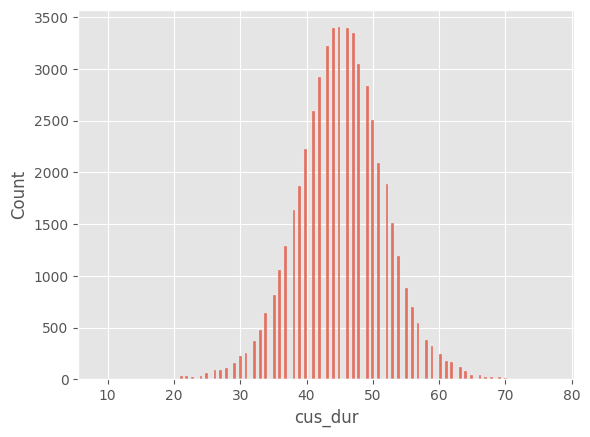

In [650]:
sns.histplot(x='cus_dur', data=df_demo)
plt.show()

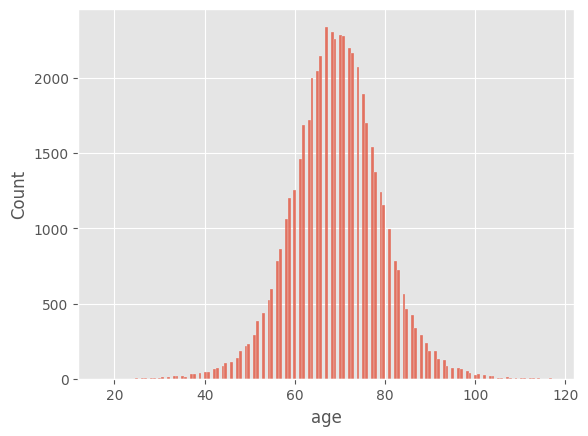

In [651]:
sns.histplot(x='age', data=df_demo)
plt.show()

<Axes: xlabel='gender', ylabel='count'>

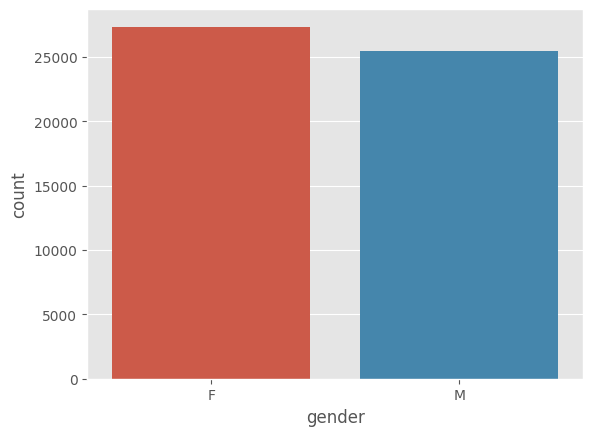

In [652]:
sns.countplot(x='gender', data=df_demo)

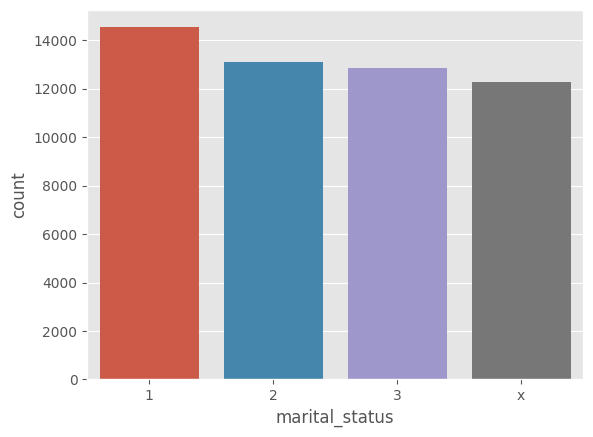

In [664]:
sns.countplot(x='marital_status', data=df_demo, order=sorted(df_demo['marital_status'].unique()))
plt.show()

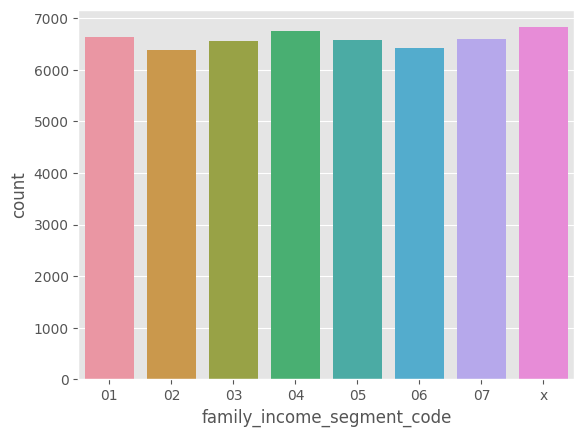

In [654]:
# sns.countplot(x='family_income_segment_code', data=df_demo, order=df_demo['family_income_segment_code'].value_counts().index)
sns.countplot(x='family_income_segment_code', data=df_demo, order=sorted(df_demo['family_income_segment_code'].unique()))
plt.show()

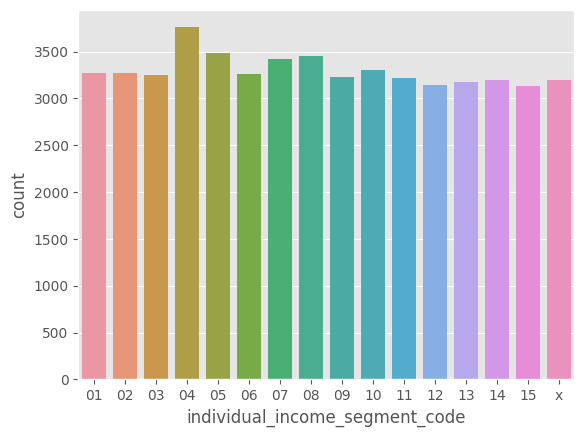

In [655]:
sns.countplot(x='individual_income_segment_code', data=df_demo, order=sorted(df_demo['individual_income_segment_code'].unique()))
plt.show()

In [665]:
famind_score = df_demo['family_income_segment_code'] + '-' + df_demo['individual_income_segment_code']
famind_score.value_counts()

05-04    490
04-04    485
x-04     481
06-04    475
x-14     467
        ... 
02-11    362
03-02    358
06-06    357
02-12    353
06-13    349
Name: count, Length: 128, dtype: int64

In [669]:
famind_score.value_counts()[:10]

05-04    490
04-04    485
x-04     481
06-04    475
x-14     467
02-07    466
01-04    465
03-04    462
02-05    459
05-05    456
Name: count, dtype: int64

In [ ]:
# df_demo['family_income_segment_code'] = df_demo['family_income_segment_code'].astype(int)
# df_demo['individual_income_segment_code'] = df_demo['individual_income_segment_code'].astype(int)

## df_cardinfo

In [ ]:
df_cardinfo.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,60296.0,25662.876028,15238.525017,0.0,12346.00,25395.5,38737.25,52761.0
bill_cyc,60296.0,15.059672,2.754340,0.0,13.00,15.0,17.00,30.0
cr_lmt_amt,60296.0,525042.987926,382398.349754,1000.0,240000.00,451000.0,723000.00,3662000.0
card_no,60296.0,30147.500000,17406.100252,0.0,15073.75,30147.5,45221.25,60295.0


In [ ]:
df_cardinfo

,user_id,bill_cyc,cr_lmt_amt,card_no
0,0,17.0,244000,0
1,1,12.0,361000,1
2,2,12.0,385000,2
3,3,15.0,518000,3
4,4,15.0,889000,4
...,...,...,...,...
60291,52757,14.0,2146000,60291
60292,52758,12.0,1273000,60292
60293,52759,16.0,1250000,60293
60294,52760,11.0,1078000,60294


<Axes: xlabel='bill_cyc', ylabel='Count'>

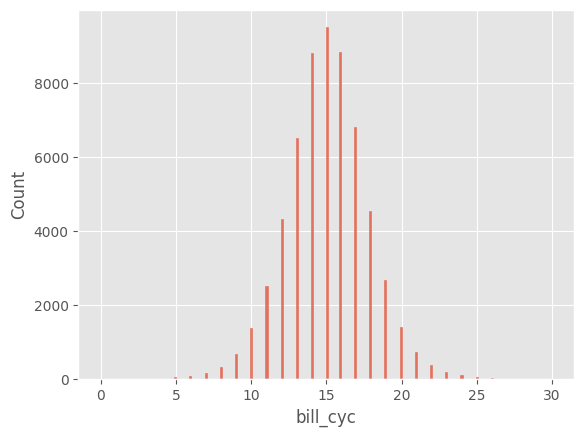

In [673]:
sns.histplot(df_cardinfo['bill_cyc'])

<Axes: xlabel='cr_lmt_amt', ylabel='Count'>

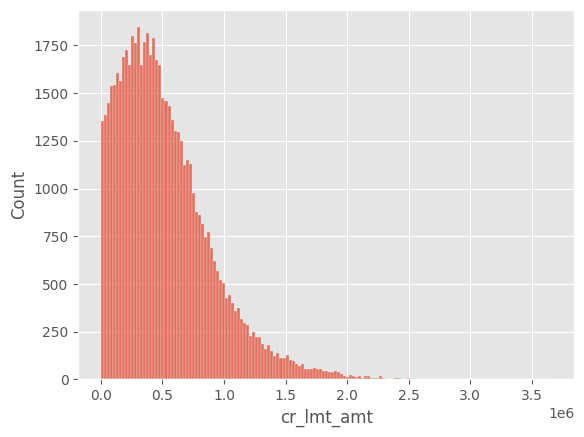

In [672]:
sns.histplot(df_cardinfo['cr_lmt_amt'])

In [ ]:
# test = pd.merge(df_cardinfo[['user_id', 'cr_lmt_amt']], df_demo[['user_id', 'individual_income_segment_code']], on='user_id')
# sns.scatterplot(x='individual_income_segment_code', y='cr_lmt_amt', data=test)

## df_cctxn

In [685]:
df_cctxn['txn_dt'] = pd.to_datetime(df_cctxn['txn_dt'])
df_cctxn['txn_month'] = df_cctxn['txn_dt'].dt.month

In [686]:
df_cctxn.head()

,mcc,txn_dt,user_id,txn_amt,card_no,txn_month
0,mcc_cat10,2017-04-12,17863,16391.0,21616.0,4
1,mcc_cat11,2017-07-12,7682,117200.0,9438.0,7
2,mcc_cat12,2017-05-23,33603,55602.0,39476.0,5
3,mcc_cat4,2017-11-03,44040,38894.0,50979.0,11
4,mcc_cat14,2017-12-18,4529,29524.0,5582.0,12


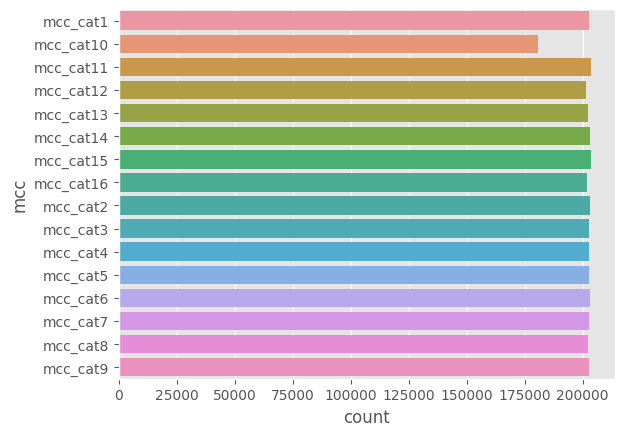

In [706]:
sns.countplot(y='mcc', data=df_cctxn, order=sorted(df_cctxn['mcc'].unique()))
# plt.xticks(rotation=90)
plt.show()

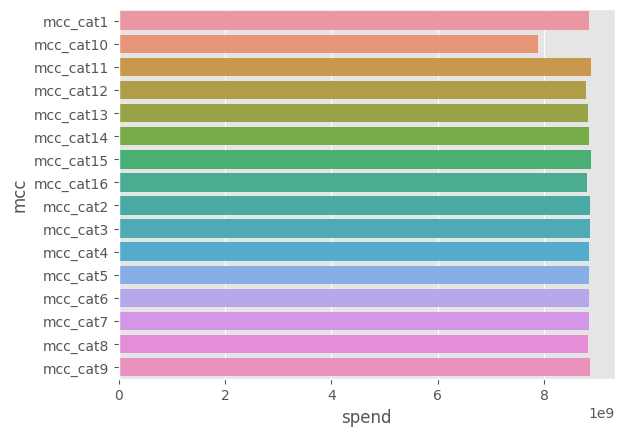

In [704]:
spend_mcc = df_cctxn.groupby('mcc').agg(spend=('txn_amt', 'sum')).reset_index()
sns.barplot(x='spend', y='mcc', data=spend_mcc)
plt.show()

In [709]:
df_cctxn_y = df_cctxn.merge(df_y, on='user_id', how='right')
df_cctxn_y.head()

,mcc,txn_dt,user_id,txn_amt,card_no,txn_month,label
0,mcc_cat11,2017-11-04,2723,125045.0,3368.0,11,1.0
1,mcc_cat13,2017-10-13,2723,130143.0,3368.0,10,1.0
2,mcc_cat16,2017-04-18,2723,24128.0,3368.0,4,1.0
3,mcc_cat2,2017-08-07,2723,40044.0,3368.0,8,1.0
4,mcc_cat12,2017-10-01,2723,54913.0,3368.0,10,1.0


## df_dtxn

### wo target

In [692]:
df_dtxn['change'] = df_dtxn['amt_in'] - df_dtxn['amt_out']
df_dtxn

,user_id,mm,amt_in,amt_out,change
0,0,1,17725.0,4490.0,13235.0
1,0,2,12431.0,29286.0,-16855.0
2,0,3,86274.0,0.0,86274.0
3,0,4,0.0,14328.0,-14328.0
4,0,5,29829.0,84557.0,-54728.0
...,...,...,...,...,...
490594,52761,3,0.0,79664.0,-79664.0
490595,52761,5,35901.0,0.0,35901.0
490596,52761,6,1306.0,37114.0,-35808.0
490597,52761,8,0.0,108236.0,-108236.0


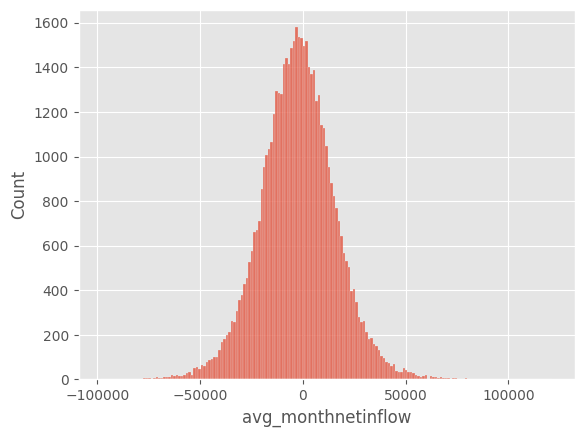

In [698]:
sns.histplot(x=df_dtxn.groupby('user_id').agg(avg_monthnetinflow=('change','mean'))['avg_monthnetinflow'])
plt.show()

### w target

In [701]:
df_dtxn_y = df_dtxn.merge(df_y, on='user_id', how='right')
df_dtxn_y.head()

,user_id,mm,amt_in,amt_out,change,label
0,2723,10,26114.0,128331.0,-102217.0,1.0
1,2723,11,0.0,54767.0,-54767.0,1.0
2,2723,2,72695.0,110524.0,-37829.0,1.0
3,2723,3,0.0,82986.0,-82986.0,1.0
4,2723,5,41468.0,47418.0,-5950.0,1.0


In [734]:
df_cctxn

,mcc,txn_dt,user_id,txn_amt,card_no,txn_month
0,mcc_cat10,2017-04-12,17863,16391.0,21616.0,4
1,mcc_cat11,2017-07-12,7682,117200.0,9438.0,7
2,mcc_cat12,2017-05-23,33603,55602.0,39476.0,5
3,mcc_cat4,2017-11-03,44040,38894.0,50979.0,11
4,mcc_cat14,2017-12-18,4529,29524.0,5582.0,12
...,...,...,...,...,...,...
3223070,mcc_cat9,2017-03-01,49742,8164.0,57110.0,3
3223071,mcc_cat8,2017-11-19,21085,31146.0,25328.0,11
3223072,mcc_cat3,2017-03-22,35306,31265.0,41396.0,3
3223073,mcc_cat11,2017-04-01,37777,11044.0,44154.0,4


# Cohort

In [761]:
df_cohort = df_cctxn.copy()
df_cohort = df_cctxn[['user_id', 'txn_month']].drop_duplicates()

df_cohort['cohort'] = df_cohort.groupby('user_id')['txn_month'].transform('min')

df_cohort = df_cohort.groupby(['cohort', 'txn_month']).agg(n_customers=('user_id', 'nunique')).reset_index(drop=False)
df_cohort['period_number'] = (df_cohort['txn_month'] - df_cohort['cohort'])

cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')

cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)

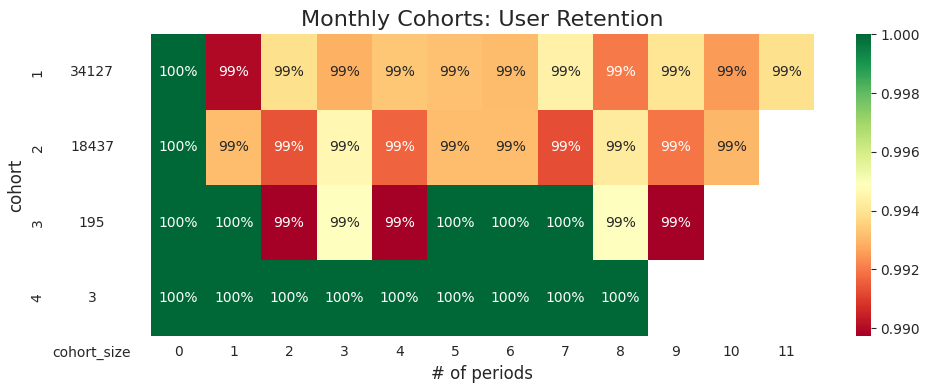

In [799]:
with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='RdYlGn', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

# Customer Movement Analysis

In [786]:
df_churn = df_cctxn.copy()
df_churn = df_churn[['user_id', 'txn_month']].drop_duplicates().sort_values(by='txn_month').reset_index(drop=True)
df_churn['start_month'] = df_churn.groupby('user_id')['txn_month'].transform('min')
df_churn['period_number'] = (df_churn['txn_month'] - df_churn['start_month'])

# df_churn = df_churn[df_churn['user_id']<2000].reset_index(drop=True)

df_churn.tail(3)

,user_id,txn_month,start_month,period_number
23188,1267,12,2,10
23189,1580,12,2,10
23190,875,12,2,10


In [787]:
# set status labels

df_churn['labels'] = df_churn.apply(lambda row: 'new' if row['txn_month'] == row['start_month'] else '', axis=1)
maxmonth = df_churn['txn_month'].max()

for user_id in df_churn['user_id'].unique() :
    period = df_churn.loc[df_churn['user_id'] == user_id, :]['period_number']
    n = 0
    
    for p in period:
        if n+1==p : 
            df_churn.loc[(df_churn['user_id'] == user_id) & (df_churn['period_number'] == p), ['labels']] = df_churn.loc[(df_churn['user_id'] == user_id) & (df_churn['period_number'] == p), ['labels']].replace('','repeat')
            n+=1

        elif n+1 < p :
            last_order = df_churn.loc[(df_churn['user_id'] == user_id) & (df_churn['period_number'] == n)]
            new_row = pd.DataFrame({'user_id': user_id, 'labels': 'churn', 'period_number':n+1, 'txn_month':last_order['txn_month'].values[0]+1}, index=[0])
            df_churn = pd.concat([new_row,df_churn.loc[:]])

            df_churn.loc[(df_churn['user_id'] == user_id) & (df_churn['period_number'] == p), ['labels']] = df_churn.loc[(df_churn['user_id'] == user_id) & (df_churn['period_number'] == p), ['labels']].replace('','reactivated')
            n=p
            
    user_maxmonth = df_churn[df_churn['user_id'] == user_id]['txn_month'].max()
    if user_maxmonth != maxmonth:
        new_row = pd.DataFrame({'user_id': user_id, 'labels': 'churn', 'period_number':p+1, 'txn_month':user_maxmonth+1}, index=[0])
        df_churn = pd.concat([new_row,df_churn.loc[:]])

df_churn.tail(3)

,user_id,labels,period_number,txn_month,start_month
23188,1267,repeat,10,12,2.0
23189,1580,repeat,10,12,2.0
23190,875,reactivated,10,12,2.0


In [788]:
df_churn_plot = pd.pivot_table(data=df_churn, values='user_id', index='txn_month', columns='labels', aggfunc='count', fill_value=0).reset_index()
df_churn_plot['churn'] = -df_churn_plot['churn']
df_churn_plot['txn_month'] = df_churn_plot['txn_month'].astype('str')

df_churn_plot.tail(3)

labels,txn_month,churn,new,reactivated,repeat
9,10,-15,0,15,1970
10,11,-14,0,15,1971
11,12,-14,0,14,1972


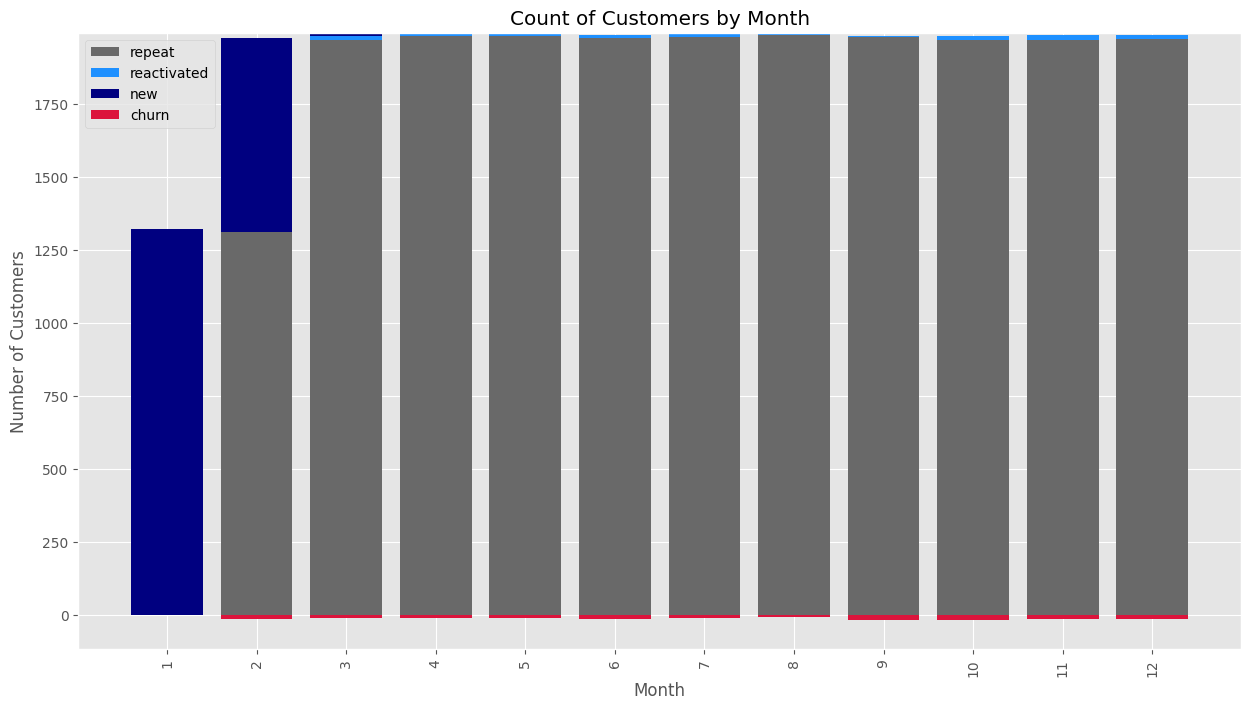

In [793]:
plt.figure(figsize=(15,8))
ax = plt.gca()
bottoms = 0 

labels = ['repeat', 'reactivated', 'new']
c = ['dimgrey', 'dodgerblue', 'navy']
for i in range(len(labels)):
  plt.bar( x = df_churn_plot['txn_month'],
           height=df_churn_plot[labels[i]],
           color = c[i],
           bottom=bottoms,
           label=labels[i])

  bottoms += df_churn_plot[labels[i]].fillna(0)

ax.bar(height=df_churn_plot['churn'], 
       x=df_churn_plot['txn_month'], 
       color='crimson', 
       bottom=0,
       label='churn')

plt.xticks(rotation='vertical')

plt.legend(loc='upper left')
plt.xlabel('Month')
plt.ylabel('Number of Customers')
plt.title('Count of Customers by Month')

plt.show()

# Feature Engineering

In [ ]:
# # Find the most bought category for each customer
# cust_dict = {'user_id':[],
#             'most_buying_cat':[]}

# cust_cat = df_cctxn.groupby(['user_id','mcc'])['mcc'].agg(qty='count').reset_index()

# for i in cust_cat['user_id'].unique():
#     cust_dict['user_id'].append(i)
#     cust = cust_cat.loc[cust_cat['user_id']==i,:]

#     if len(cust.loc[cust['qty']==cust['qty'].max()]['mcc']) == 1:
#         cust_dict['most_buying_cat'].append(cust.loc[cust['qty']==cust['qty'].max()]['mcc'].reset_index(drop=True)[0])
#     elif len(cust.loc[cust['qty']==cust['qty'].max()]['mcc']) > 1:
#         # if most buying cat more than one convert to list
#         cust_dict['most_buying_cat'].append(list(cust.loc[cust['qty']==cust['qty'].max()]['mcc']))

In [727]:
# create feature df
df_feature = df_demo[['user_id']].drop_duplicates().sort_values(by='user_id').reset_index(drop=True)

# aggreate data and merge with feature dataframe

# Credit card transaction log dataframe
df_feature = df_feature.merge(
    df_cctxn.groupby('user_id').agg(
        card_count = ('card_no', 'nunique'), # number of cards
        total_spend = ('txn_amt', 'sum'), # total spending
        avg_spend = ('txn_amt', 'mean'), # average spending
        count_txn = ('txn_amt', 'count'), # count of transaction
        last_txn = ('txn_dt', 'max'), # last transaction
        count_day = ('txn_dt', 'nunique'), # count of day transaction happened
        count_month = ('txn_month', 'nunique') # count of month transaction happened
    ), on='user_id')

# aggregate for 3 months period
df_feature = df_feature.merge(
    df_cctxn.loc[df_cctxn['txn_month'] > (df_cctxn['txn_month'].max() - 3), :].groupby('user_id').agg(
        count_txn_3m = ('txn_amt', 'count'), # total spending
        total_spend_3m = ('txn_amt', 'sum'), # count of transaction
        avg_spend_3m = ('txn_amt', 'mean'), # average spending
        count_day_3m = ('txn_dt', 'nunique'), # count of day transaction happened
        count_month_3m = ('txn_month', 'nunique'), # count of month transaction happened
    ), on='user_id')

# aggregate for 6 months period
df_feature = df_feature.merge(
    df_cctxn.loc[df_cctxn['txn_month'] > (df_cctxn['txn_month'].max() - 6), :].groupby('user_id').agg(
        count_txn_6m = ('txn_amt', 'count'), # total spending
        total_spend_6m = ('txn_amt', 'sum'), # count of transaction
        avg_spend_6m = ('txn_amt', 'mean'), # average spending
        count_day_6m = ('txn_dt', 'nunique'), # count of day transaction happened
        count_month_6m = ('txn_month', 'nunique') # count of month transaction happened
    ), on='user_id')

# recency = duration between last transaction of customer and 2017-12-31
df_feature['recency'] = (df_cctxn['txn_dt'].max() - df_feature['last_txn']).dt.days

################################

# Saving account balance aggregated by months dataframe
df_feature = df_feature.merge(
    df_sabal.groupby('user_id').agg(
        avg_sabal_month = ('max_sa_bal', 'mean') # avg saving balance by months
        ), on='user_id')
        
################################

# Incoming and outgoing transactions aggregated by months (exclude credit card transactions) dataframe
df_feature = df_feature.merge(
    df_dtxn.groupby('user_id').agg(
        # avg_balchg_month = ('change', 'mean'),
        total_txnchg = ('change', 'sum'), # total net income transaction
        ), on='user_id')

################################

# # join with most buying cat df
# df_feature = df_feature.merge(pd.DataFrame(cust_dict), how='inner', on='user_id')

df_feature.drop(columns=['last_txn'], inplace=True)

df_feature.head()

,user_id,card_count,total_spend,avg_spend,count_txn,count_day,count_month,count_txn_3m,total_spend_3m,avg_spend_3m,count_day_3m,count_month_3m,count_txn_6m,total_spend_6m,avg_spend_6m,count_day_6m,count_month_6m,recency,avg_sabal_month,total_txnchg
0,0,1,1746107.0,31180.482143,56,53,12,15,504694.0,33646.266667,13,3,27,852850.0,31587.037037,25,6,3,355838.916667,-29603.0
1,1,1,2234391.0,34912.359375,64,56,12,25,784067.0,31362.680000,22,3,37,1220829.0,32995.378378,32,6,0,317793.166667,-77698.0
2,2,1,1632778.0,37971.581395,43,38,11,12,442390.0,36865.833333,12,3,23,815837.0,35471.173913,21,5,10,405045.333333,214644.0
3,3,1,2884456.0,64099.022222,45,42,10,17,974785.0,57340.294118,15,3,32,1914940.0,59841.875000,30,6,6,513779.666667,162985.0
4,4,1,2973483.0,69150.767442,43,39,10,11,773503.0,70318.454545,10,2,21,1327124.0,63196.380952,19,5,0,391910.083333,-675871.0


In [728]:
df_feature_train = df_feature.merge(df_y, on='user_id')
# df_feature_train.drop(columns=['most_buying_cat'], inplace=True)
df_feature_train.head()

,user_id,card_count,total_spend,avg_spend,count_txn,count_day,count_month,count_txn_3m,total_spend_3m,avg_spend_3m,...,count_month_3m,count_txn_6m,total_spend_6m,avg_spend_6m,count_day_6m,count_month_6m,recency,avg_sabal_month,total_txnchg,label
0,10,1,2267081.0,44452.568627,51,48,11,14,594988.0,42499.142857,...,3,28,1201221.0,42900.750000,27,6,0,291653.000000,-318380.0,0.0
1,47,1,1727249.0,32589.603774,53,49,11,11,285450.0,25950.000000,...,3,29,981797.0,33855.068966,26,6,0,493508.000000,262929.0,0.0
2,262,1,1861840.0,42314.545455,44,38,12,10,451322.0,45132.200000,...,3,24,940753.0,39198.041667,21,6,0,358678.333333,-150956.0,0.0
3,366,2,3741925.0,35637.380952,105,94,12,25,966898.0,38675.920000,...,3,57,2135298.0,37461.368421,51,6,10,327767.750000,227699.0,0.0
4,612,2,4287773.0,40072.644860,107,94,12,31,1514201.0,48845.193548,...,3,61,2512421.0,41187.229508,53,6,4,476089.333333,-166999.0,0.0


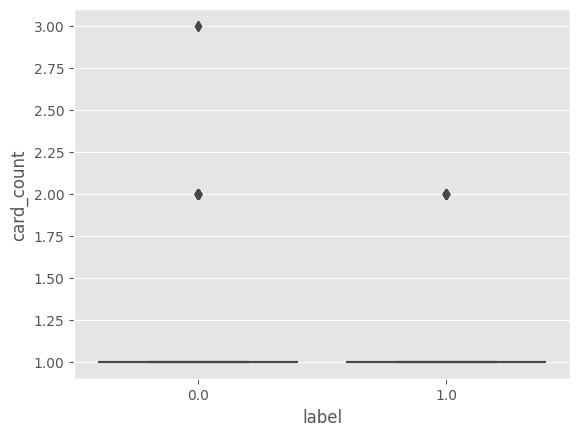

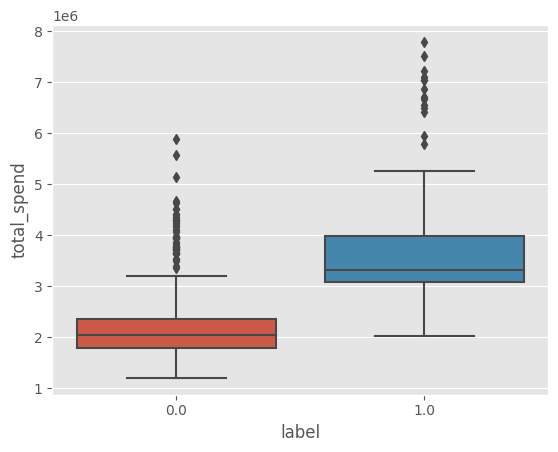

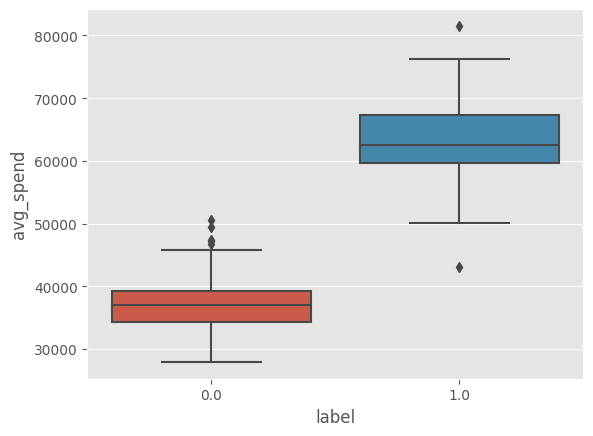

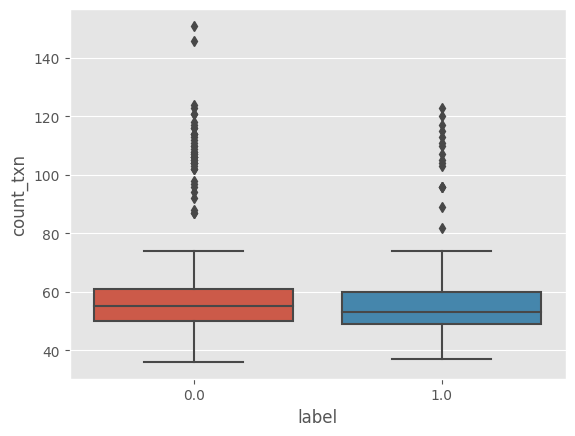

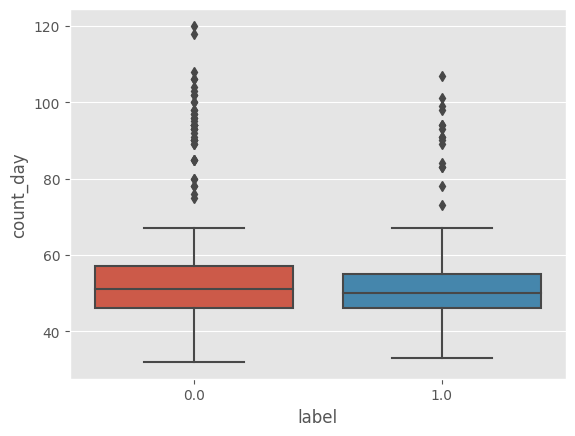

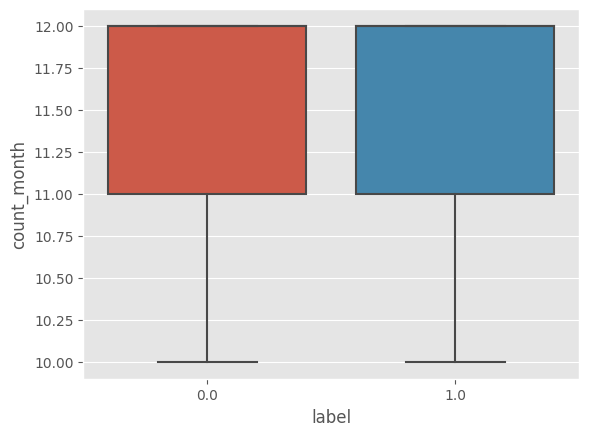

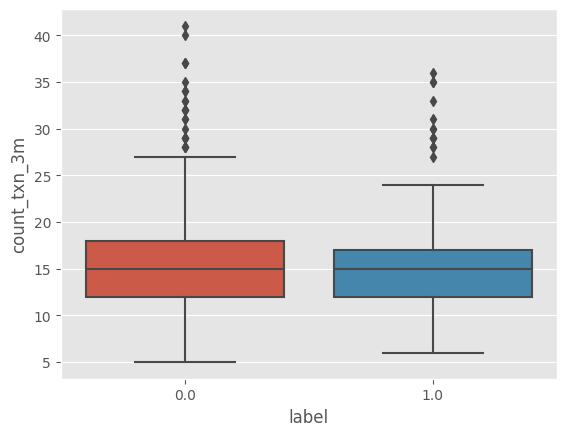

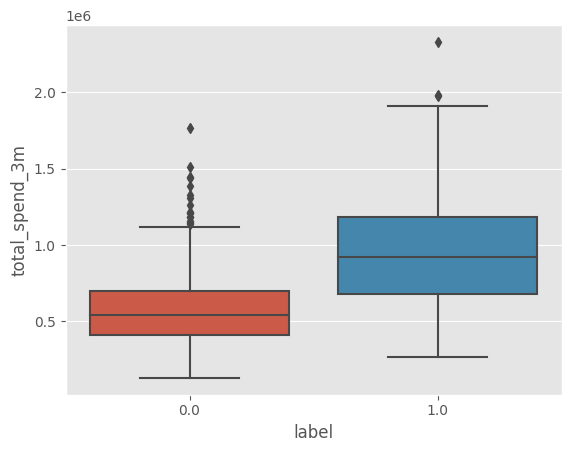

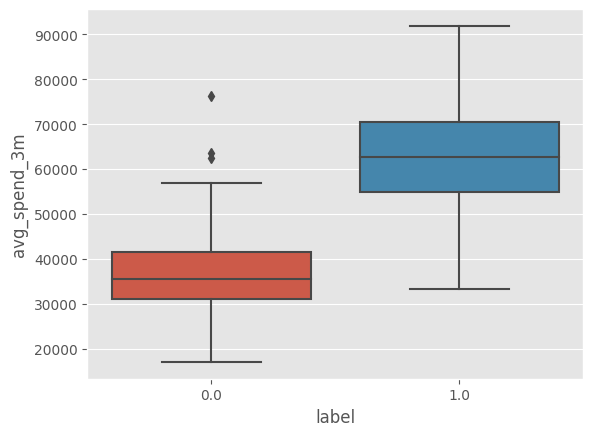

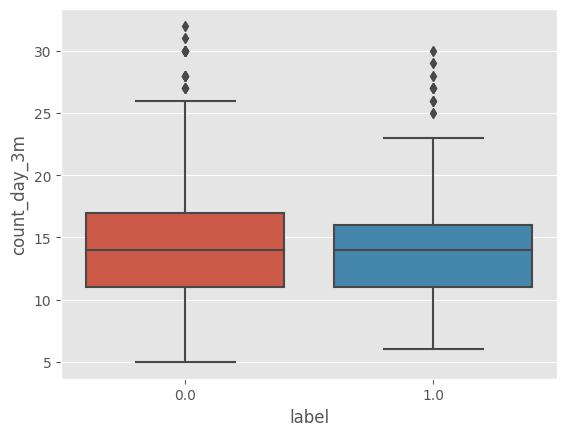

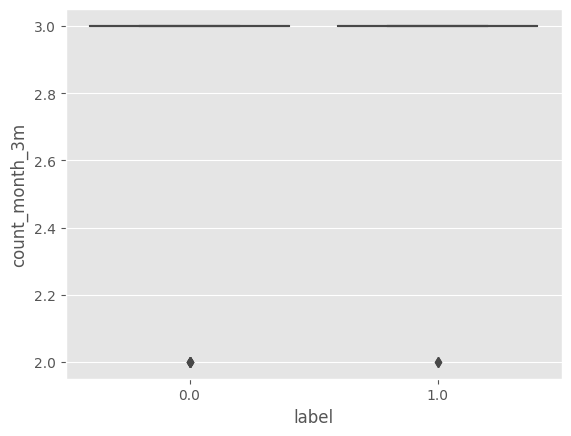

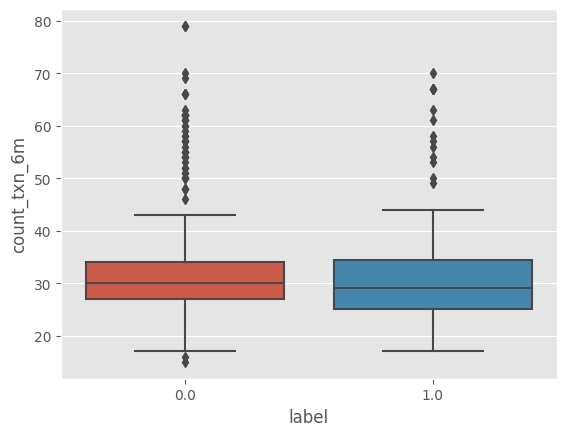

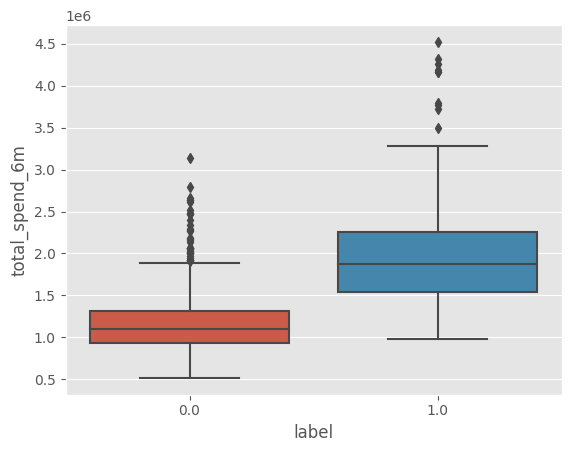

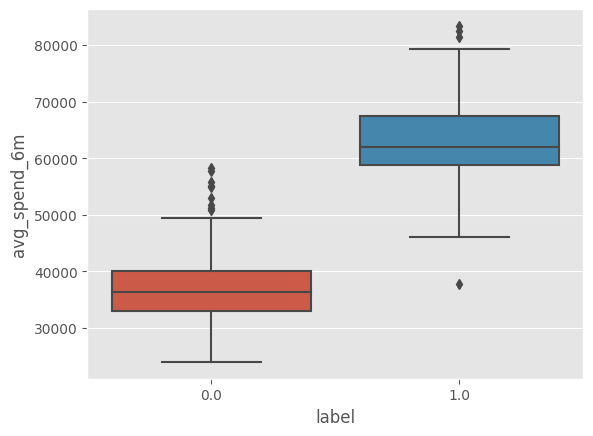

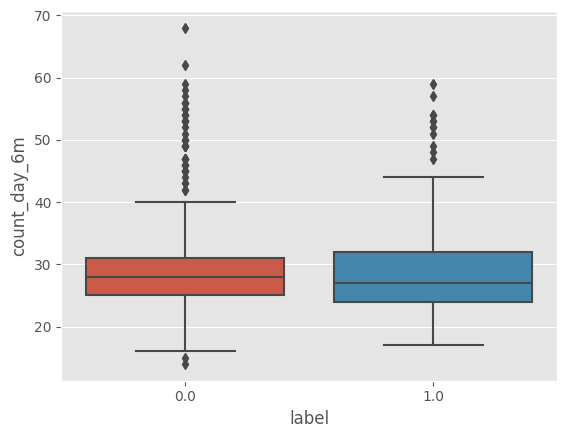

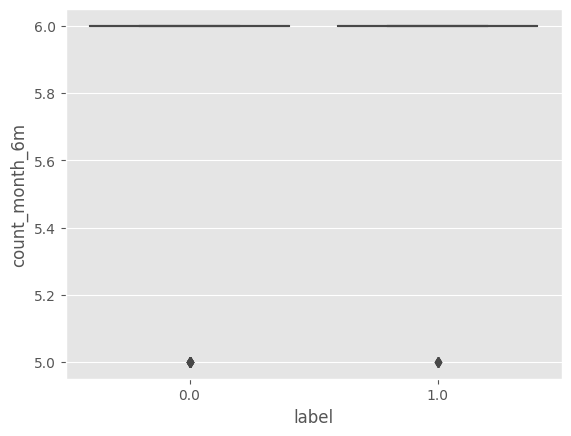

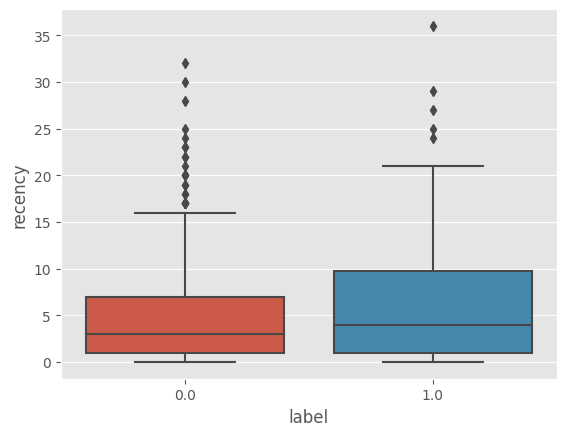

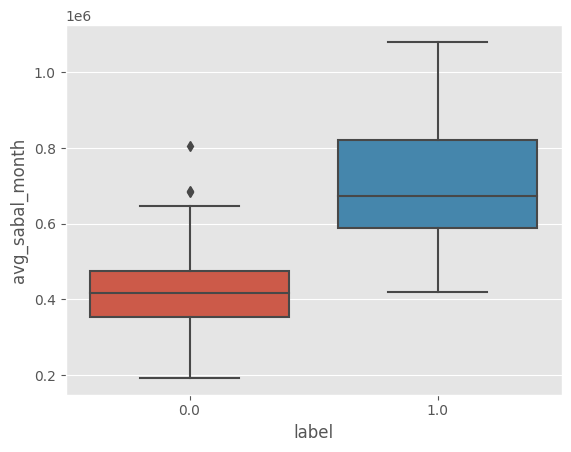

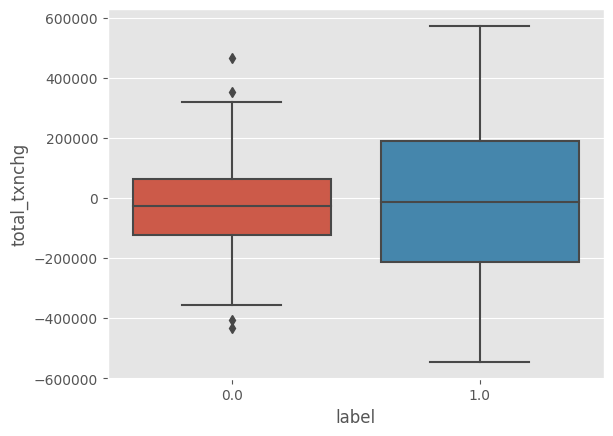

In [729]:
for col in df_feature_train.columns[1:-1]:
    sns.boxplot(x='label', y=col, data=df_feature_train)
    plt.show()

# Model and Evaluation

In [ ]:
# X = df_feature_train.drop(columns=['user_id', 'label'])
X = df_feature_train.drop(columns=['user_id', 'label'])
y = df_feature_train['label']

X_col = X.columns

# scaler = MinMaxScaler()
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

model = RandomForestClassifier(random_state=random_state)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00       108
         1.0       0.98      1.00      0.99        41

    accuracy                           0.99       149
   macro avg       0.99      1.00      0.99       149
weighted avg       0.99      0.99      0.99       149



In [ ]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f2 = 5*precision*recall/((4*precision)+recall)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F2: {f2:.4f}')

Precision: 0.9762
Recall: 1.0000
F2: 0.9951


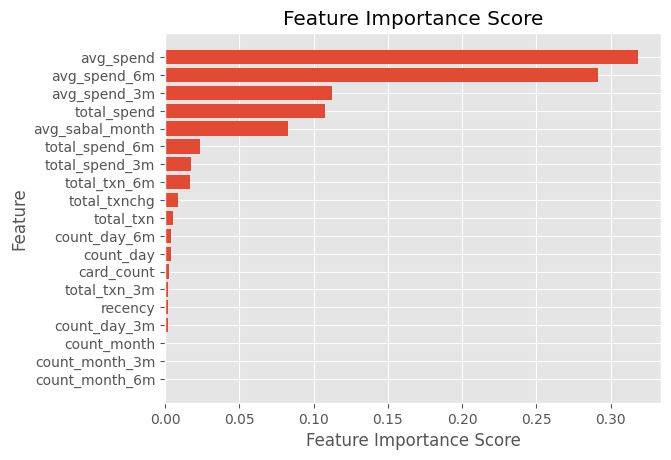

In [ ]:
# Create a Random Forest classifier
model = RandomForestClassifier(random_state=random_state)

# Train the classifier on your data
model.fit(X, y)

# Get the feature importance scores
importance_scores = model.feature_importances_

# Sort the features based on importance in descending order
sorted_indices = np.argsort(importance_scores)[::-1]

# Plotting the feature importance
plt.barh(range(len(sorted_indices)), importance_scores[sorted_indices], align='center')
plt.yticks(range(len(sorted_indices)), [df_feature_train.columns[idx+1] for idx in sorted_indices])
plt.xlabel('Feature Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance Score')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top
plt.show()

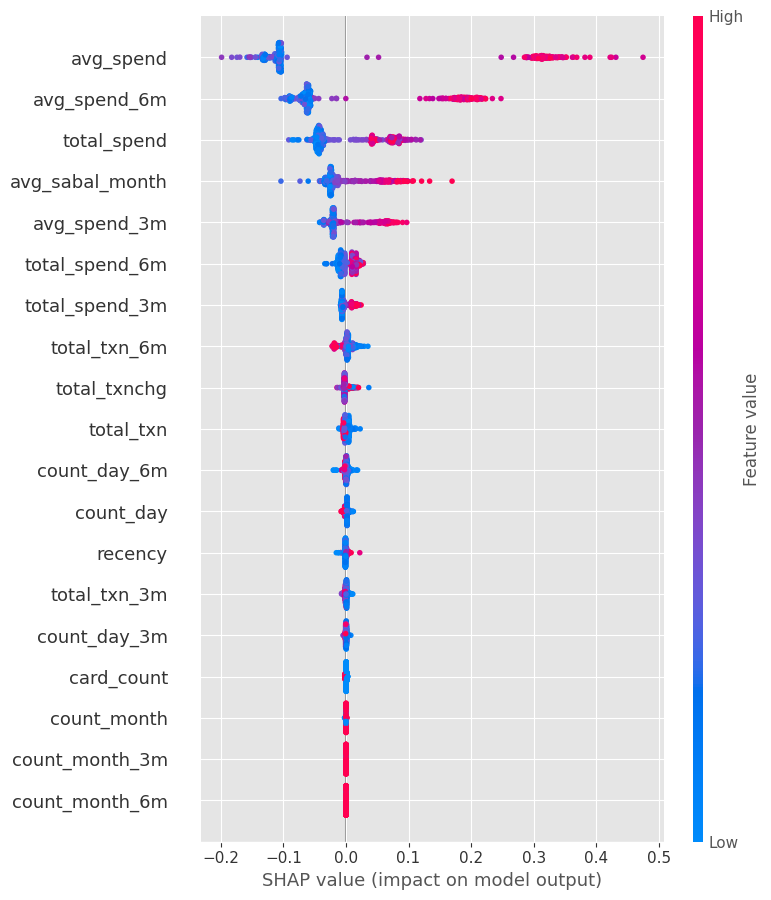

In [ ]:
# Explain the model predictions using SHAP values
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# Create a SHAP summary plot
shap.summary_plot(shap_values[1], X, feature_names=X_col)

![image.png](attachment:image.png)

In [ ]:
df_feature_train.loc[df_feature_train['label']==0,['avg_spend']].mean()

avg_spend    36953.594292
dtype: float64

In [ ]:
df_feature_train.loc[df_feature_train['label']==1,['avg_spend']].mean()

avg_spend    63168.191867
dtype: float64

# Optional Model

In [ ]:
df_cctxn_q1_3 = df_cctxn.loc[df_cctxn['txn_month']<=9,:]
df_cctxn_q4 = df_cctxn.loc[df_cctxn['txn_month']>9,:][['user_id']].drop_duplicates()

In [ ]:
df_cctxn_q1_3.nunique()

mcc              16
txn_dt          248
user_id       52762
txn_amt      172330
card_no       60296
txn_month         9
txn_day          31
dtype: int64

In [ ]:
df_cctxn_q4.nunique()

user_id    52761
dtype: int64

In [ ]:
# # create feature df
# df_feature = df_demo[['user_id']].drop_duplicates().sort_values(by='user_id').reset_index(drop=True)

# # aggreate data and merge with feature dataframe

# # Credit card transaction log dataframe
# df_feature = df_feature.merge(
#     df_cctxn_q1_3.groupby('user_id').agg(
#         card_count = ('card_no', 'nunique'), # number of cards
#         total_spend = ('txn_amt', 'sum'), # total spending
#         avg_spend = ('txn_amt', 'mean'), # average spending
#         total_txn = ('txn_amt', 'count'), # count of transaction
#         last_txn = ('txn_dt', 'max'), # last transaction
#         count_day = ('txn_dt', 'nunique'), # count of day transaction happened
#         count_month = ('txn_month', 'nunique') # count of month transaction happened
#     ), on='user_id')

# # aggregate for 3 months period
# df_feature = df_feature.merge(
#     df_cctxn_q1_3.loc[df_cctxn_q1_3['txn_month'] > (df_cctxn_q1_3['txn_month'].max() - 3), :].groupby('user_id').agg(
#         total_txn_3m = ('txn_amt', 'count'), # total spending
#         total_spend_3m = ('txn_amt', 'sum'), # count of transaction
#         avg_spend_3m = ('txn_amt', 'mean'), # average spending
#         count_day_3m = ('txn_dt', 'nunique'), # count of day transaction happened
#         count_month_3m = ('txn_month', 'nunique'), # count of month transaction happened
#     ), on='user_id')

# # aggregate for 6 months period
# df_feature = df_feature.merge(
#     df_cctxn_q1_3.loc[df_cctxn_q1_3['txn_month'] > (df_cctxn_q1_3['txn_month'].max() - 6), :].groupby('user_id').agg(
#         total_txn_6m = ('txn_amt', 'count'), # total spending
#         total_spend_6m = ('txn_amt', 'sum'), # count of transaction
#         avg_spend_6m = ('txn_amt', 'mean'), # average spending
#         count_day_6m = ('txn_dt', 'nunique'), # count of day transaction happened
#         count_month_6m = ('txn_month', 'nunique') # count of month transaction happened
#     ), on='user_id')

# # recency = duration between last transaction of customer and 2017-09-30
# df_feature['recency'] = (df_cctxn_q1_3['txn_dt'].max() - df_feature['last_txn']).dt.days

# ################################

# # Saving account balance aggregated by months dataframe
# df_feature = df_feature.merge(
#     df_sabal.loc[df_sabal['mm']<=9, :].groupby('user_id').agg(
#         avg_sabal_month = ('max_sa_bal', 'mean') # avg saving balance by months
#         ), on='user_id')
        
# ################################

# # Incoming and outgoing transactions aggregated by months (exclude credit card transactions) dataframe
# df_feature = df_feature.merge(
#     df_dtxn.loc[df_dtxn['mm']<=9, :].groupby('user_id').agg(
#         total_txnchg = ('change', 'sum'), # total net income transaction
#         ), on='user_id')

# ################################

# df_feature.drop(columns=['last_txn'], inplace=True)

# df_feature.head()

In [725]:
df_cctxn.groupby('user_id').agg(count_txn=('txn_amt', 'count')).reset_index

,count_txn
user_id,
0,56
1,64
2,43
3,45
4,43
...,...
52757,41
52758,53
52759,55


In [733]:
df_feature[df_feature['count_txn']<30]

,user_id,card_count,total_spend,avg_spend,count_txn,count_day,count_month,count_txn_3m,total_spend_3m,avg_spend_3m,count_day_3m,count_month_3m,count_txn_6m,total_spend_6m,avg_spend_6m,count_day_6m,count_month_6m,recency,avg_sabal_month,total_txnchg
12009,12009,1,881232.0,32638.222222,27,26,10,6,206528.0,34421.333333,6,3,13,461411.0,35493.153846,12,6,15,579029.666667,-49631.0
35074,35075,1,1006824.0,34718.068966,29,28,11,9,207085.0,23009.444444,9,3,15,334236.0,22282.400000,14,6,3,416239.916667,-173004.0
49750,49751,1,844913.0,32496.653846,26,25,10,4,161784.0,40446.000000,4,3,10,299086.0,29908.600000,10,6,1,416860.583333,-47475.0
